# Test DEMV on Obesity Dataset

- Positive label: `Normal_Weight`
- Protected group: `Gender: 1, Age: 1`

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
def prepare_data():
  data = pd.read_csv('data2/obesity.csv')
  data.drop(['NObeyesdad', 'weight_cat', 'yhat', 'a'], axis=1, inplace=True)
  le = LabelEncoder()
  data['Gender'] = le.fit_transform(data['Gender'].values)
  data['y'].replace({
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 2,
    'Obesity_Type_I': 3,
    'Insufficient_Weight': 4
  }, inplace=True)
  data['family_history_with_overweight']=le.fit_transform(data['family_history_with_overweight'].values)
  data['FAVC'] = le.fit_transform(data['FAVC'].values)
  data['CAEC'] = le.fit_transform(data['CAEC'].values)
  data['SMOKE'] = le.fit_transform(data['SMOKE'].values)
  data['SCC'] = le.fit_transform(data['SCC'].values)
  data['CALC'] = le.fit_transform(data['CALC'].values)
  data['MTRANS'] = le.fit_transform(data['MTRANS'].values)
  data.loc[data['Age'] < 22 , 'Age'] = 0
  data.loc[data['Age'] >= 22, 'Age'] = 1
  return data

In [3]:
data = prepare_data()

In [4]:
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,y
0,0,0.0,1.620000,64.000000,1,0,2.000000,3.000000,2,0,2.000000,0,0.000000,1.000000,3,3,0
1,0,0.0,1.520000,56.000000,1,0,3.000000,3.000000,2,1,3.000000,1,3.000000,0.000000,2,3,0
2,1,1.0,1.800000,77.000000,1,0,2.000000,3.000000,2,0,2.000000,0,2.000000,1.000000,1,3,0
3,1,1.0,1.800000,87.000000,0,0,3.000000,3.000000,2,0,2.000000,0,2.000000,0.000000,1,4,1
4,1,1.0,1.780000,89.800000,0,0,2.000000,1.000000,2,0,2.000000,0,0.000000,0.000000,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,1,0.0,1.705304,99.873716,1,1,2.000000,1.293342,2,0,2.000000,0,0.000000,1.917679,3,3,3
1486,0,0.0,1.612910,82.193405,1,1,1.261288,2.930044,2,0,1.166655,0,0.133398,0.951740,3,3,3
1487,0,0.0,1.605469,82.039000,1,1,2.765330,3.000000,2,0,1.048584,0,0.192559,0.720411,3,3,3
1488,1,0.0,1.804160,104.406820,1,1,2.000000,3.000000,2,0,3.000000,0,2.240500,0.000000,3,3,3


<AxesSubplot:>

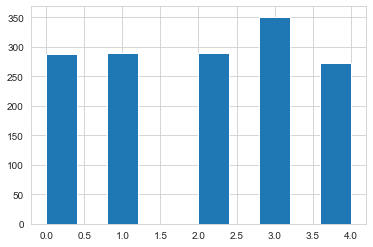

In [5]:
data['y'].hist()

In [6]:
data = data.loc[data['y'] != 4]

In [7]:
label = 'y'
positive_label = 0
protected_group = {'Gender': 1, 'Age': 1}
sensitive_vars = ['Gender', 'Age']

In [8]:
pipeline = Pipeline(steps=[
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [9]:
model, metrics = cross_val(pipeline, data, label, protected_group, sensitive_vars, positive_label)
print_metrics(metrics)

Statistical parity:  -0.103  +-  0.1
Disparate impact:  0.564  +-  0.267
Zero one loss:  0.124  +-  0.042
F1 score:  0.929  +-  0.021
Accuracy score:  0.929  +-  0.021


## DEMV classifier

In [10]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [11]:
model, demv_metrics = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_vars, debiaser=demv, positive_label=positive_label)
print_metrics(demv_metrics)

Statistical parity:  -0.1  +-  0.106
Disparate impact:  0.562  +-  0.27
Zero one loss:  0.105  +-  0.051
F1 score:  0.932  +-  0.024
Accuracy score:  0.932  +-  0.025


## DEMV Evaluation

In [12]:
iters = demv.get_iters()

In [13]:
iters

38

In [14]:
metrics = eval_demv(10, iters, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

##  Blackbox Postprocessing

In [15]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.0000  0.9333
1  0.0667  1.0000
2  0.0196  0.8333
3  0.0000  0.9444

1
      fpr     tpr
0  0.0227  0.9333
1  0.0588  0.6250
2  0.0857  0.9167
3  0.0000  0.9167


And loss is 0.0902


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.0000  0.9167
1  0.0714  1.0000
2  0.0208  0.8333
3  0.0000  0.9444

1
      fpr    tpr
0  0.0256  0.900
1  0.0488  0.625
2  0.0690  0.950
3  0.0000  1.000


And loss is 0.0826

[9.00000000e-01 8.76985631e-02 1.23014369e-02 6.62661596e-12]
[2.09086349e-01 6.43296408e-01 1.47617242e-01 6.22639704e-12]
[3.48477249e-02 1.93143890e-01 7.72008385e-01 6.84407584e-12]
[1.90559647e-12 5.72852146e-03 4.98270341e-02 9.44444444e-01]
[9.00000000e-01 1.00000000e-01 2.74238274e-12 9.15198400e-13]
[1.53543490e-01 6.43296408e-01 2.03160101e-01 3.52092717e-12]
[1.08465263e-01 1.19526352e-01 7.72008385e-01 1.05167574e-11]
[1.60215218e-12 1.42824217e-12 5.55555556e-02 9.44444444e-01]

Pre-adjustment group rates

ValueError: could not broadcast input array from shape (4,3) into shape (4,4)

##  Plot

In [ ]:
df = prepareplots(metrics, 'obesity')

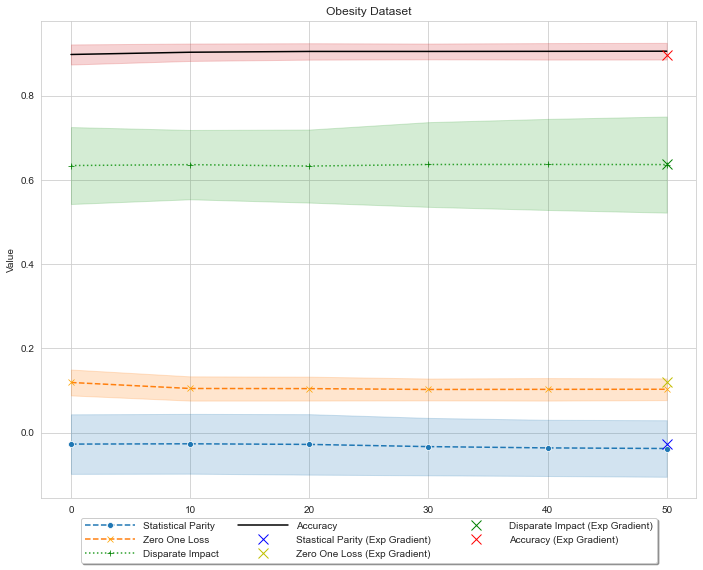

In [ ]:
points = preparepoints(blackboxmetrics, 50)

plot_metrics_curves(df, points, 'Obesity Dataset')

In [ ]:
unprivpergentage(data, protected_group, 52)

Dataset size: 1490
Unprivileged group size: 361
Percentage of unprivileged group: 24.22818791946309
Number of iterations: 52
